In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import yfinance as yf
import os


senti_data = pd.read_csv('sentiment_data.csv')

senti_data['date'] = pd.to_datetime(senti_data['date'])


senti_data = senti_data.set_index(['date', 'symbol'])

senti_data['engagement_ratio'] = senti_data['Comments']/senti_data['Likes']

senti_data = senti_data[(senti_data['Likes']>200)&(senti_data['Comments']>100)]

senti_data

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19276\3302484372.py:12: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  senti_data['date'] = pd.to_datetime(senti_data['date'])


Post  Comments    Likes  response  Sentiment  \
date       symbol                                                 
2021-11-18 AAPL     811      2592    21674   7981808        NaN   
           AMD      150       675     2949   1645270        NaN   
           AMZN     557      1315    12969   5590695        NaN   
           CRM       25      7183    29832    142826        NaN   
           ES        54       308     1008    157878        NaN   
...                 ...       ...      ...       ...        ...   
2023-01-04 T        184      3409    14271    884935   0.590457   
           TSLA    6767    540711  3810688  55464921   0.543057   
           TSN       35       168      460     57207   0.561900   
           V        132      1008     5943    139835   0.567286   
           XOM      212       374     2071    483389   0.588914   

                   engagement_ratio  
date       symbol                    
2021-11-18 AAPL            0.119590  
           AMD             0.228891  
           AMZN            0.101396  
           CRM             0.240782  
           ES              0.305556  
...                             ...  
2023-01-04 T               0.238876  
           TSLA            0.141893  
           TSN             0.365217  
           V               0.169611  
           XOM             0.180589  

[19685 rows x 6 columns]

In [4]:
grouped_df = (senti_data.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

grouped_df['rank'] = (grouped_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

grouped_df


engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.134342  44.0
           AAPL            0.256318  17.0
           ABBV            0.214665  30.0
           ABT             0.235784  21.0
           AES             0.864613   3.0
...                             ...   ...
2023-01-31 TMO             0.333313  18.0
           TSLA            0.151992  65.0
           TSN             0.382881  11.0
           V               0.194045  55.0
           XOM             0.217904  48.0

[1067 rows x 2 columns]

In [5]:
fil_df = grouped_df[grouped_df['rank']<6].copy()

fil_df = fil_df.reset_index(level=1)

fil_df.index = fil_df.index+pd.DateOffset(1)

fil_df = fil_df.reset_index().set_index(['date', 'symbol'])

fil_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   3.0
           DAL             0.876160   2.0
           FCX             0.681592   5.0
           MNST            0.747044   4.0
           OXY             2.452192   1.0
2022-01-01 BA              0.650160   4.0
           FCX             0.875800   3.0
           LUV             1.515975   1.0
           MA              0.883401   2.0
           OXY             0.619203   5.0
2022-02-01 AMD             0.715556   3.0
           D               2.212764   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.688089   4.0
2022-03-01 D               0.757943   4.0
           FCX             1.160840   2.0
           LUV             1.574377   1.0
           MRO             0.672717   5.0
           OXY             1.025579   3.0

In [6]:
dates = fil_df.index.get_level_values('date').unique().tolist()

fd = {}

for d in dates:
    
    fd[d.strftime('%Y-%m-%d')] = fil_df.xs(d, level=0).index.tolist()
    
fd

{'2021-12-01': ['AES', 'DAL', 'FCX', 'MNST', 'OXY'],
 '2022-01-01': ['BA', 'FCX', 'LUV', 'MA', 'OXY'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['D', 'FCX', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'DD', 'PFE', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'DD', 'J', 'PM'],
 '2022-06-01': ['AMD', 'DD', 'EL', 'KEY', 'LMT'],
 '2022-07-01': ['CRM', 'DD', 'EA', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'NCLH', 'STZ'],
 '2022-09-01': ['DIS', 'L', 'META', 'MRNA', 'PYPL'],
 '2022-10-01': ['AES', 'DD', 'FCX', 'KEY', 'META'],
 '2022-11-01': ['A', 'FCX', 'META', 'MNST', 'STZ'],
 '2022-12-01': ['AES', 'DAL', 'J', 'RCL', 'STZ'],
 '2023-01-01': ['AES', 'C', 'DAL', 'KEY', 'RCL'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'DAL', 'MDT']}

In [7]:
for d in dates:
    
    fd[d.strftime('%Y-%m-%d')] = fil_df.xs(d, level=0).index.tolist()
    
fd

list_of_stocks = senti_data.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=list_of_stocks,
                        start='2021-01-01',
                        end='2023-03-01')


returns_df = np.log(prices_df['Adj Close']).diff().dropna()

new_df = pd.DataFrame()

for start_date in fd.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fd[start_date]
    
    t_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    new_df = pd.concat([new_df, t_df], axis=0)
    
new_df


[*********************100%%**********************]  85 of 85 completed


,portfolio_return
Date,
2021-12-01,-0.029638
2021-12-02,0.036095
2021-12-03,-0.010800
2021-12-06,0.030387
2021-12-07,0.025085
...,...
2023-02-22,-0.004235
2023-02-23,0.001294
2023-02-24,-0.006892


[*********************100%%**********************]  1 of 1 completed


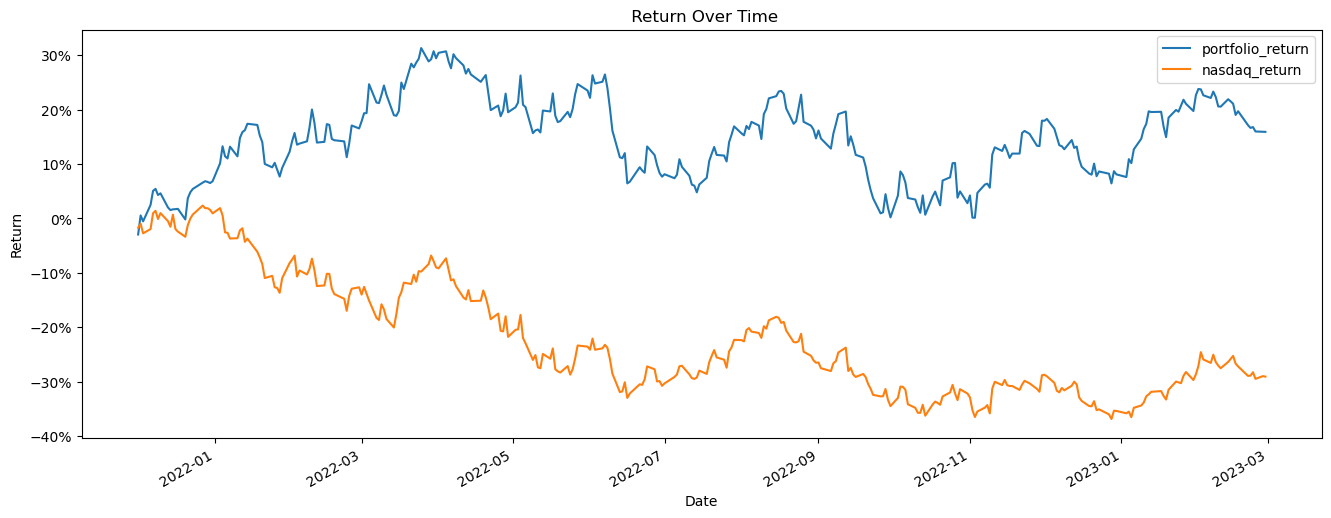

In [8]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

new_df = new_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

new_df

portfolios_cumulative_return = np.exp(np.log1p(new_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title(' Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19276\3681976292.py:12: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  senti_data['date'] = pd.to_datetime(senti_data['date'])


[*********************100%%**********************]  85 of 85 completed
[*********************100%%**********************]  1 of 1 completed


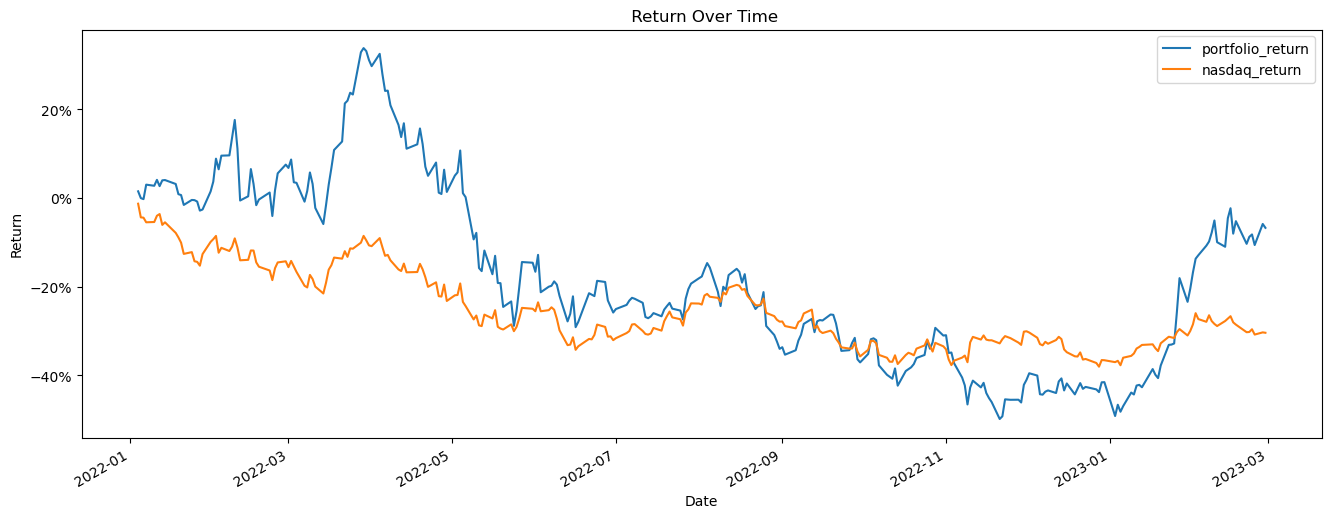

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import yfinance as yf
import os


senti_data = pd.read_csv('sentiment_data.csv')

senti_data['date'] = pd.to_datetime(senti_data['date'])


senti_data = senti_data.set_index(['date', 'symbol'])

senti_data['engagement_ratio'] = senti_data['Comments']/senti_data['Likes']

senti_data = senti_data[(senti_data['Likes']>200)&(senti_data['Comments']>100)]

senti_data

grouped_df = (senti_data.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

grouped_df['rank'] = (grouped_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

grouped_df


fil_df = grouped_df[grouped_df['rank']<6].copy()

fil_df = fil_df.reset_index(level=1)

fil_df.index = fil_df.index+pd.DateOffset(1)

fil_df = fil_df.reset_index().set_index(['date', 'symbol'])

fil_df.head(20)

dates = fil_df.index.get_level_values('date').unique().tolist()

fd = {}

for d in dates:
    
    fd[d.strftime('%Y-%m-%d')] = fil_df.xs(d, level=0).index.tolist()
    
fd

list_of_stocks = senti_data.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=list_of_stocks,
                        start='2022-01-01',
                        end='2023-11-01')


returns_df = np.log(prices_df['Adj Close']).diff().dropna()

new_df = pd.DataFrame()

for start_date in fd.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fd[start_date]
    
    t_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    new_df = pd.concat([new_df, t_df], axis=0)
    
new_df

qqq_df = yf.download(tickers='QQQ',
                     start='2022-01-01',
                     end='2023-11-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

new_df = new_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

new_df

portfolios_cumulative_return = np.exp(np.log1p(new_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title(' Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19276\3679962474.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  senti_data['date'] = pd.to_datetime(senti_data['date'])


[*********************100%%**********************]  85 of 85 completed
[*********************100%%**********************]  1 of 1 completed


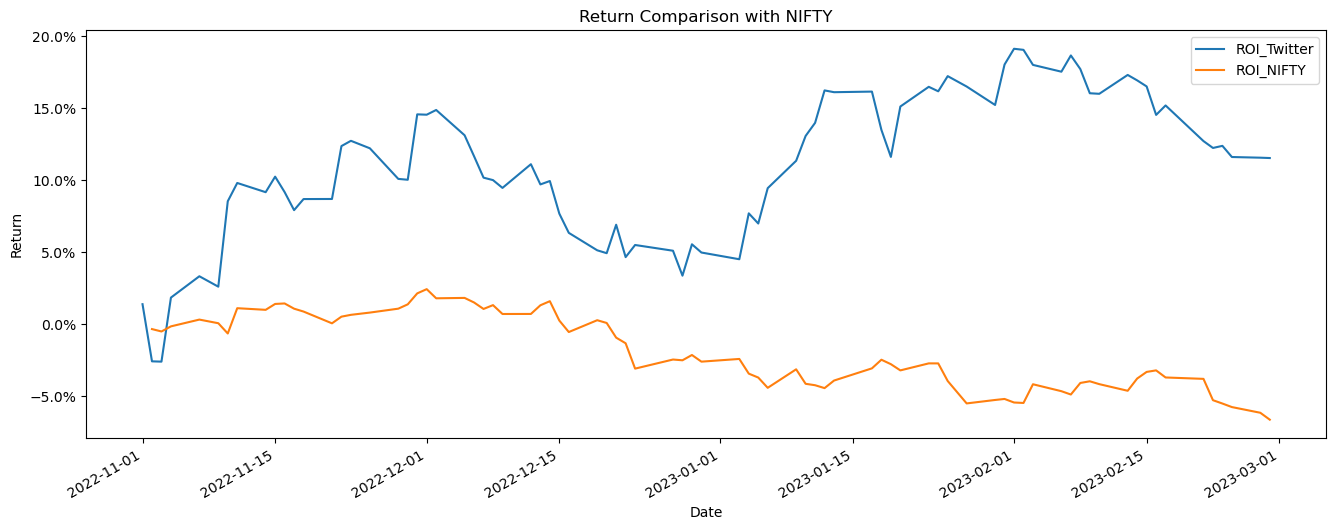

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import yfinance as yf
import os

# Load sentiment data
senti_data = pd.read_csv('sentiment_data.csv')
senti_data['date'] = pd.to_datetime(senti_data['date'])
senti_data = senti_data.set_index(['date', 'symbol'])
senti_data['engagement_ratio'] = senti_data['Comments'] / senti_data['Likes']
senti_data = senti_data[(senti_data['Likes'] > 200) & (senti_data['Comments'] > 100)]

# Group sentiment data by month and symbol
grouped_df = (senti_data.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
              [['engagement_ratio']].mean())
grouped_df['rank'] = (grouped_df.groupby(level=0)['engagement_ratio']
                     .transform(lambda x: x.rank(ascending=False)))

# Filter the top 5 symbols for each month
fil_df = grouped_df[grouped_df['rank'] < 6].copy()
fil_df = fil_df.reset_index(level=1)
fil_df.index = fil_df.index + pd.DateOffset(1)
fil_df = fil_df.reset_index().set_index(['date', 'symbol'])

# Get unique dates and list of stocks
dates = fil_df.index.get_level_values('date').unique().tolist()
fd = {}
for d in dates:
    fd[d.strftime('%Y-%m-%d')] = fil_df.xs(d, level=0).index.tolist()

list_of_stocks = senti_data.index.get_level_values('symbol').unique().tolist()

# Download stock prices for the selected stocks
prices_df = yf.download(tickers=list_of_stocks,
                        start='2022-01-01',
                        end='2023-11-01')

# Calculate returns for the selected stocks
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

# Create a DataFrame to store the returns of the strategy
new_df = pd.DataFrame()

# Calculate strategy returns for each selected period
for start_date in fd.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    cols = fd[start_date]
    t_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('ROI_Twitter')
    new_df = pd.concat([new_df, t_df], axis=0)

# Download NIFTY data
nifty_df = yf.download(tickers='^NSEI',
                       start='2022-11-01',
                       end='2023-11-01')

# Calculate NIFTY returns
nifty_ret = np.log(nifty_df['Adj Close']).diff().to_frame('ROI_NIFTY')

# Merge NIFTY returns with strategy returns
new_df = new_df.merge(nifty_ret, left_index=True, right_index=True)

# Calculate cumulative returns
portfolios_cumulative_return = np.exp(np.log1p(new_df).cumsum()).sub(1)

# Plot cumulative returns
portfolios_cumulative_return.plot(figsize=(16, 6))
plt.title('Return Comparison with NIFTY')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()
